# Sensitivity analysis

In [1]:
from SALib.sample import saltelli, fast_sampler
from SALib.sample import ff as ffs
from SALib.analyze import sobol, fast, ff
from SALib.plotting.bar import plot as barplot
import numpy as np
import pandas as pd
import shutil
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px

In [2]:
# parameter dictionary
problem = {
    'num_vars': 3,
    'names': ['random-mating', 'leakage', 'fertility'],
    'bounds': [[0, 0.75],
               [0, 0.50],
               [0, 0.30]]
}

# Sobol

In [ ]:
sample_parameters = False
if (sample_parameters):
    param_values = saltelli.sample(problem, 2**12)
    t = pd.DataFrame(param_values)
    t.columns = ["random-mating", "leakage", "fertility"]
    t.to_csv("../models/fertility-BMI/data/param-sobol.csv", index=False)
else:
    t = pd.read_csv("../models/fertility-BMI/data/param-sobol.csv")
len(t)

In [ ]:
df = pd.read_csv("../output/data/results-sobol.csv", sep = ";")
cols = df.bmi_group_prop.str.replace(r'\[|\]', '').str.split(",", n=4, expand=True)
colnames = ['g'+str(i+1) for i in range(4)]
cols.columns = colnames
cols = cols[colnames].apply(pd.to_numeric)
df = pd.concat([df, cols], axis=1, ignore_index=False)
params = pd.read_csv("../output/data/param-sobol.csv", sep = ";")
df = df.merge(params, on = ["iteration", "replicate"])
df["iteration"] = pd.to_numeric(df["iteration"])
df = df.sort_values(by=['iteration'])
df = df.loc[df["iteration"] <= len(t),:]
Y = df["g4"].to_numpy()
len(Y)

In [ ]:
Si = sobol.analyze(problem, Y, print_to_console=True)

In [ ]:
total, first, second = Si.to_df()

In [ ]:
st = barplot(total)
plt.savefig("../output/plots/sobol-st.pdf", bbox_inches='tight')
s1 = barplot(first)
plt.savefig("../output/plots/sobol-s1.pdf", bbox_inches='tight')
s2 = barplot(second)
plt.savefig("../output/plots/sobol-s2.pdf", bbox_inches='tight')

shutil.copy("../output/plots/sobol-st.pdf", "../manuscript/plots/")
shutil.copy("../output/plots/sobol-s1.pdf", "../manuscript/plots/")
shutil.copy("../output/plots/sobol-s2.pdf", "../manuscript/plots/")

In [ ]:
fig = px.scatter_3d(df, x='random_mating', y='fertility_factor', z='leakage',
              color='g4', color_continuous_scale = px.colors.sequential.OrRd)

fig.update_traces(marker=dict(size=4, opacity = 0.4),
                  selector=dict(mode='markers'))
fig.update_layout(scene = dict(
                    xaxis_title='random mating',
                    yaxis_title='fertility',
                    zaxis_title='leakage'),
                    width=700,
                    margin=dict(r=10, b=10, l=10, t=10), 
                    coloraxis_colorbar=dict(title="Obese")
                    )
fig.show()

In [ ]:
# fig.write_image("../output/plots/3D-scatter-sobol.pdf")
shutil.copy("../output/plots/3D-scatter-sobol.png", "../manuscript/plots/")

# EFast

In [5]:

sample_parameters = False
if (sample_parameters):
    param_values = fast_sampler.sample(problem, 2000)
    t = pd.DataFrame(param_values)
    t.columns = ["random-mating", "leakage", "fertility"]
    t.to_csv("../models/fertility-BMI/data/param-efast.csv", index=False)
else:
    t = pd.read_csv("../models/fertility-BMI/data/param-efast.csv")
t.shape

(6000, 3)

In [6]:
df = pd.read_csv("../output/data/results-efast.csv", sep = ";")
cols = df.bmi_group_prop.str.replace(r'\[|\]', '').str.split(",", n=4, expand=True)
colnames = ['g'+str(i+1) for i in range(4)]
cols.columns = colnames
cols = cols[colnames].apply(pd.to_numeric)
df = pd.concat([df, cols], axis=1, ignore_index=False)
params = pd.read_csv("../output/data/param-efast.csv", sep = ";")
df = df.merge(params, on = ["iteration", "replicate"])
df["iteration"] = pd.to_numeric(df["iteration"])
df = df.sort_values(by=['iteration'])
df = df.loc[df["iteration"] <= len(t),:]
Y = df["g4"].to_numpy()
len(Y)


<ipython-input-6-3f9ef571fc7e>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  cols = df.bmi_group_prop.str.replace(r'\[|\]', '').str.split(",", n=4, expand=True)


4000

In [9]:
params.loc[params["iteration"] <= 6000,:]

,iteration,replicate,init_pop,fertility_type,heritability_type,mating_type,random_mating,leakage,fertility_factor
0,1,1,2000,additive,preston,defined,0.635561,0.423707,0.254224
1,10,1,2000,additive,preston,defined,0.683689,0.428207,0.262076
2,100,1,2000,additive,preston,defined,0.376189,0.473207,0.025076
3,1000,1,2000,additive,preston,defined,0.301189,0.076793,0.055076
4,1001,1,2000,additive,preston,defined,0.114439,0.076293,0.045776
...,...,...,...,...,...,...,...,...,...
6002,995,1,2000,additive,preston,defined,0.265061,0.079293,0.101576
6003,996,1,2000,additive,preston,defined,0.451811,0.078793,0.092276
6004,997,1,2000,additive,preston,defined,0.638561,0.078293,0.082976
6005,998,1,2000,additive,preston,defined,0.674689,0.077793,0.073676


In [11]:
df.loc[df["iteration"] <= 6000,:]

,iteration,replicate,time,population,bmi_group_prop,mating,kid-father-cor,kid-mother-cor,g1,g2,g3,g4,init_pop,fertility_type,heritability_type,mating_type,random_mating,leakage,fertility_factor
0,1,1,100.0,3082,"[0.10674886437378325, 0.20733290071382218, 0.3...",0.110129,0.431749,0.407124,0.106749,0.207333,0.373459,0.312459,2000,additive,preston,defined,0.635561,0.423707,0.254224
1111,2,1,100.0,3588,"[0.1335005574136009, 0.23049052396878483, 0.34...",0.069241,0.424033,0.373957,0.133501,0.230491,0.343924,0.292085,2000,additive,preston,defined,0.677689,0.424207,0.263524
2222,3,1,100.0,2491,"[0.10036130068245684, 0.21878763548775593, 0.3...",0.267632,0.473749,0.457781,0.100361,0.218788,0.370534,0.310317,2000,additive,preston,defined,0.490939,0.424707,0.272824
3333,4,1,100.0,4414,"[0.11758042591753512, 0.2310829179882193, 0.38...",0.511508,0.544234,0.537284,0.117580,0.231083,0.384232,0.267105,2000,additive,preston,defined,0.304189,0.425207,0.282124
4444,5,1,100.0,4225,"[0.08733727810650888, 0.22106508875739644, 0.4...",0.796456,0.609890,0.605082,0.087337,0.221065,0.403077,0.288521,2000,additive,preston,defined,0.117439,0.425707,0.291424
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5551,5996,1,100.0,3685,"[0.10746268656716418, 0.2016282225237449, 0.36...",0.322147,0.566757,0.545672,0.107463,0.201628,0.367978,0.322931,2000,additive,preston,defined,0.440125,0.218417,0.195950
5552,5997,1,100.0,3604,"[0.14428412874583796, 0.2097669256381798, 0.35...",0.339518,0.572959,0.561189,0.144284,0.209767,0.350721,0.295228,2000,additive,preston,defined,0.440875,0.233917,0.121250
5553,5998,1,100.0,2562,"[0.18618266978922718, 0.2923497267759563, 0.29...",0.333767,0.572382,0.564504,0.186183,0.292350,0.290008,0.231460,2000,additive,preston,defined,0.441625,0.249417,0.046550
5554,5999,1,100.0,2817,"[0.21512247071352503, 0.31203407880724177, 0.3...",0.334573,0.567751,0.549665,0.215122,0.312034,0.303514,0.169329,2000,additive,preston,defined,0.442375,0.264917,0.028150


In [20]:
Sif = fast.analyze(problem, Y, print_to_console=True)

                     S1        ST   S1_conf   ST_conf
random-mating  0.001499  0.136604  0.004543  0.017443
leakage        0.517378  0.789595  0.003823  0.018026
fertility      0.180721  0.469495  0.003911  0.018420


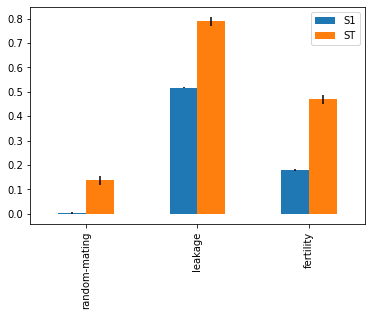

In [21]:
Sif.plot()
plt.savefig("../output/plots/efast.pdf", bbox_inches='tight')

In [22]:
shutil.copy("../output/plots/efast.pdf", "../manuscript/plots/")

'../manuscript/plots/efast.pdf'

In [23]:
fig = px.scatter_3d(df, x='random_mating', y='fertility_factor', z='leakage',
              color='g4', color_continuous_scale = px.colors.sequential.OrRd)

fig.update_traces(marker=dict(size=4, opacity = 0.7),
                  selector=dict(mode='markers'))
fig.update_layout(scene = dict(
                    xaxis_title='random mating',
                    yaxis_title='fertility',
                    zaxis_title='leakage'),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10), 
                    coloraxis_colorbar=dict(title="Obese")
                    )
fig.show()

In [ ]:
#fig.write_image("../output/plots/3D-scatter-efast.pdf")
shutil.copy("../output/plots/3D-scatter-efast.png", "../manuscript/plots/")

# eFast with replicates

In [27]:

sample_parameters = False

if (sample_parameters):
    param_values = fast_sampler.sample(problem, 500)
    
    t = pd.DataFrame(param_values)
    t.columns = ["random-mating", "leakage", "fertility"]
    t.to_csv("../models/fertility-BMI/data/param-rep-efast.csv", index=False)
else:
    t = pd.read_csv("../models/fertility-BMI/data/param-rep-efast.csv")
t.shape

(1500, 3)

In [28]:
df = pd.read_csv("../output/data/results-rep-efast.csv", sep = ";")
params = pd.read_csv("../output/data/param-rep-efast.csv", sep = ";")
df = df.merge(params, on = ["iteration", "replicate"])
df["iteration"] = pd.to_numeric(df["iteration"])
df["replicate"] = pd.to_numeric(df["replicate"])
df = df.sort_values(by=['iteration'])
df = df.loc[df["iteration"] <= len(t),:]

In [14]:
replicates = df.replicate.sort_values().unique()
Y = {}
for i in replicates:
    tY = df.loc[df["replicate"] == i].g4.to_numpy()
    Y[i] = fast.analyze(problem, tY, print_to_console=False)
    Y[i]["replicate"] = i

In [9]:
# testing
a = df.loc[df["replicate"] == 3].g4.to_numpy()
tsif = fast.analyze(problem, a, print_to_console=True)

                     S1        ST   S1_conf   ST_conf
random-mating  0.003605  0.289156  0.017053  0.033964
leakage        0.444692  0.781835  0.017987  0.036907
fertility      0.181110  0.456463  0.015730  0.040940


In [24]:
# create dataset
columns = Y[1]["names"]
S1 = []
ST = []
replicates = []

for value in Y.values():
    replicates.append(value["replicate"])
    S1.append(value["S1"])
    ST.append(value["ST"])

S1 = pd.DataFrame(np.row_stack(S1))
S1.columns = columns
ST = pd.DataFrame(np.row_stack(ST))
ST.columns = columns
S1["replicate"] = replicates
ST["replicate"] = replicates

In [26]:
S1.tail()

,random-mating,leakage,fertility,replicate
25,0.001411,0.492030,0.188665,26
26,0.002543,0.434848,0.224697,27
27,0.008254,0.493067,0.209296,28
28,0.003304,0.539186,0.201565,29
29,0.004892,0.492199,0.225373,30


In [11]:
S1.describe()

,random-mating,leakage,fertility
count,30.000000,30.000000,30.000000
mean,0.003953,0.482336,0.198723
std,0.001941,0.034053,0.022490
min,0.001023,0.410207,0.142722
25%,0.002597,0.454800,0.188906
50%,0.003735,0.490393,0.199509
75%,0.005271,0.497370,0.212532
max,0.008254,0.546634,0.253188


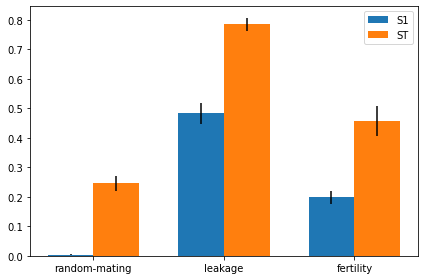

'../manuscript/plots/efast-rep.pdf'

In [32]:
# create plot
labels = columns
s1_means = S1.describe().loc["mean",].to_numpy()
st_means = ST.describe().loc["mean",].to_numpy()
s1_errors = S1.describe().loc["std",].to_numpy()
st_errors= ST.describe().loc["std",].to_numpy()


width = 0.35  # the width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, s1_means, width, label='S1', yerr=s1_errors)
rects2 = ax.bar(x + width/2, st_means, width, label='ST', yerr=st_errors)

# Add some text for labels, title and custom x-axis tick labels, etc.

# ax.set_ylabel('Scores')
# ax.set_title('Scores by group and gender')
ax.set_xticks(np.arange(len(labels))  )
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()
plt.show()

fig.savefig("../output/plots/efast-rep.pdf", bbox_inches='tight')
shutil.copy("../output/plots/efast-rep.pdf", "../manuscript/plots/")